In [1]:
import pyemma
import os
import sys
[sys.path.remove(loc) for loc in sys.path if 'pytraj' in loc] #I need this to import the correct version of pytraj
import pytraj as pt
import numpy as np
import matplotlib.pyplot as plt
from scripts.scripts import calculate_rmsd

## Markov State Models

Now that all of the required seeded MD simulations have run, we can use the trajectory data to construct a Markov State Model (MSM). [PyEMMA](http://emma-project.org/latest/) is a python library for this, and has their own [tutorials](http://emma-project.org/latest/tutorial.html). This is just an example of how an MSM could be built, for more details please refer to PyEMMA documentation.

### Get data

Markov State Models generally do not use all atom coordinates to define configurations since then no configuration would be visited more than once on a realistic time scale. Therefore, we have to perform dimensionality reduction in the form of featurising data, i.e. reducing the trajectories to time series of feature values. In this case we will be using RMSD to the closed WPD loop PTP1B conformation (backbone atoms only), and the distance between peptide substrate PTry(P) and Cys215(S) of the protein. These have been chosen as the starting point based on the specific function of PTP1B and will depend on each system.

<img src="figures/msm_features.png" width=350>

Start by having a list of trajectory files that will be loaded and featurised one by one. I do this by specifying the two directories I have my files in (one for steering from open to closed and one for steering from closed to open) and loop over 100 seeded MD trajectories I know I have. The exact structure will depend on how you have structured your seeded MD data.

In [2]:
data_dirs = ['/home/adele/Documents/PTP1B-open-peptide_BSS/', '/home/adele/Documents/PTP1B-closed-peptide/']
traj_files = []
topology_files = []
#loop over 100 seeded MD trajectories in each directory
for directory in data_dirs:
    for i in range(1,101):
        traj_files.append(f'{directory}/seeded/snapshot_{i}/production_dry.nc')
        topology_files.append(f'{directory}/seeded/snapshot_{i}/system_dry.prm7')

The two lists should look something like this:

In [3]:
print(traj_files[:2])
print(topology_files[:2])

['/home/adele/Documents/PTP1B-open-peptide_BSS//seeded/snapshot_1/production_dry.nc', '/home/adele/Documents/PTP1B-open-peptide_BSS//seeded/snapshot_2/production_dry.nc']
['/home/adele/Documents/PTP1B-open-peptide_BSS//seeded/snapshot_1/system_dry.prm7', '/home/adele/Documents/PTP1B-open-peptide_BSS//seeded/snapshot_2/system_dry.prm7']


Note that I am also including the topology files as I will need those to load AMBER trajectories. Additionally, I am using dry trajectories - this simply means that data processing will take much less time, as less atoms need to be loaded. That is okay for this case, since water is not important to the selected features.

### Featurise the data

Now is the time to load the trajectories one by one and compute the feature values. I will be using [pytraj](https://amber-md.github.io/pytraj/latest/index.html) (python version of AMBER's [cpptraj](https://amber-md.github.io/cpptraj/CPPTRAJ.xhtml)), mainly because PyEMMA's way of calculating RMSD does not allow to specify separate alignment and RMSD atoms. A script for calculating RMSD with pytraj is provided and imported as a function at the start.

At this point we also need to load the RMSD reference.

In [3]:
reference = pt.load('/home/adele/Documents/preparing-ptp1b/for-use/ptp1b-closed.pdb')

In [4]:
data_dirs = ['/home/adele/Documents/PTP1B-open-peptide_BSS/', '/home/adele/Documents/PTP1B-closed-peptide/']
traj_files = []
topology_files = []
#loop over 100 seeded MD trajectories in each directory
for directory in data_dirs:
    for i in range(1,101):
        traj_files.append(f'{directory}/seeded/snapshot_{i}/msm_data.txt')
        topology_files.append(f'{directory}/seeded/snapshot_{i}/rmsd_up_to_CA_toclosed.txt')

In [5]:
data = []
for i in range(len(traj_files)):
    rmsd = np.loadtxt(topology_files[i])
    dist = np.loadtxt(traj_files[i])
    current_traj = []
    for j in range(len(rmsd)):
        current_traj.append([rmsd[j], dist[j*2][0]])
    data.append(np.array(current_traj))

In [5]:
data = []
for i in range(len(traj_files)):
    print(i+1, end='\r')
    traj = pt.load(traj_files[i], top=topology_files[i], stride=2)
    rmsd = calculate_rmsd(traj, reference, ':179-185&(@CA,N,C,O)')
    distance = pt.calc_distance(traj, ':216@SG @P')
    current_traj = []
    for j in range(len(rmsd)):
        current_traj.append([rmsd[j], distance[j]])
    data.append(np.array(current_traj))

The above might take a while depending on how much data is being used. I have also added a print for the current file being processed (out of 200 in this case) to track progress. I am also loading every other frame here, which gives a 10 ps timestep. This makes analysis a bit faster, and previous work on this system indicates that the lag times will be much larger than 10 ps.

The resulting list `data` has 200 numpy arrays, one for each trajectory. Each array has the shape (10000, 2) - 10000 frames and 2 features per frame.

Alternatively you can also process the data beforehand and load the results. This might be especially preferable if you want to test different features/feature combinations, as it saves you having to process the data multiple times.

### Plotting data

PyEMMA has some nice in-built plotting functionality.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Feature values'>)

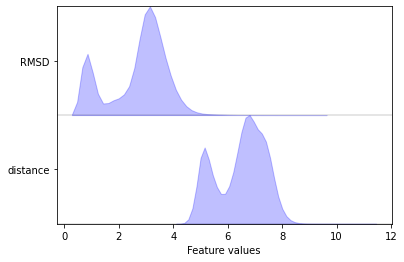

In [6]:
pyemma.plots.plot_feature_histograms(np.vstack(data), feature_labels=['RMSD', 'distance'])

Text(0, 0.5, 'distance')

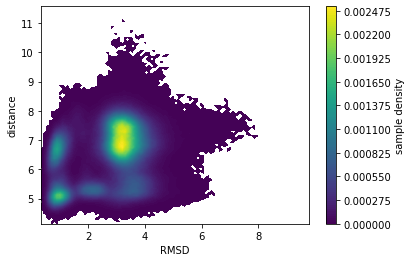

In [7]:
fig, ax, misc = pyemma.plots.plot_density(np.vstack(data)[:,0], np.vstack(data)[:,1])
ax.set_xlabel('RMSD')
ax.set_ylabel('distance')

### Clustering

In addition to reducing the seeded MD trajectories to selected features, we also group the feature values into states through k-means clustering. The Markov State Model will describe the transition probabilities between these cluster states.

In [8]:
clusters = pyemma.coordinates.cluster_kmeans(np.vstack(data), k=100, max_iter=50)

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

06-05-21 09:39:07 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


We can visualize the clusters by plotting:

Text(0.5, 0, 'RMSD')

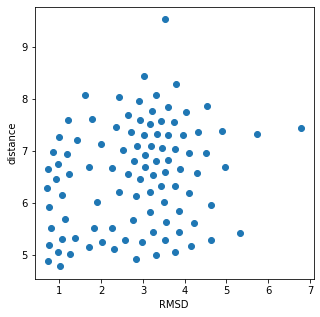

In [9]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(clusters.clustercenters[:,0], clusters.clustercenters[:,1])
ax.set_ylabel('distance')
ax.set_xlabel('RMSD')

Now we need to assign the trajectory data to clusters. So each frame will be reduced to belonging to clusters 1-100. This is the final stage of dimensionality reduction for our data. It can also take a long time sometimes!

In [10]:
dtrajs = pyemma.coordinates.assign_to_centers(data=data, centers=clusters.clustercenters)

getting output of AssignCenters:   0%|          | 0/200 [00:00<?, ?it/s]

### Check implied timescales

Implied timescales are the relaxation timescales of a system, implied by an MSM. ITS should not depend on the lag time $\tau$. This does not happen for small $\tau$ since the errors of the model are large. The goal is to find an appropriately large value of $\tau$ while making it small enough to have sufficient statistical information from the trajectory data (e.g. if $\tau$ is greater than 100 ns in our case, we have no data for the model). We check the implied timescales for our system by building a number of trial models with different lag times.

In [26]:
lags_to_try = [1,5,10,25,50,100,250,500,750,1000,1250,1500,1750,2000,2500,3000,4000,5000]

In [12]:
its = pyemma.msm.timescales_msm(dtrajs, lags=lags_to_try, nits=10, errors='bayes')

estimating BayesianMSM:   0%|          | 0/18 [00:00<?, ?it/s]

We can visualize ITS via PyEMMA:

<AxesSubplot:xlabel='lag time / steps', ylabel='timescale / steps'>

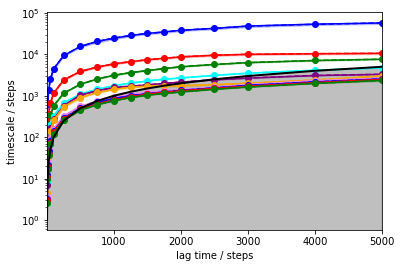

In [13]:
pyemma.plots.plot_implied_timescales(its)

The ITS curves reach a point where they are independent of the lag time at around 2000 steps. This is the lag time that will be used for the MSM. Additionally, we can see 3 distinct slowest processed (curves that do not overlap), which suggests the model can differentiate between 3 metastable states.

### Build MSM

After all the preparatory work, building the actual MSM is a single line. Note that the lag time chosen is 2000 steps, or 20 ns.

In [36]:
msm = pyemma.msm.bayesian_markov_model(dtrajs, 2000)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[16]: compute stat. inefficiencies:   0%|          | 0/7795 [00:…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[16]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

We have to check states and counts used, to make sure that all states are connected. A disconnected state is one that is not transitioned to or from any other states. In this case, all of the states were used, and we can proceed. Otherwise we would have to remove the disconnected states and rebuild a new MSM.

In [28]:
print(f'Fraction of states used = {msm.active_state_fraction}')
print(f'Fraction of counts used = {msm.active_count_fraction}')

Fraction of states used = 1.0
Fraction of counts used = 1.0


### CK test

One of the ways to assess an MSM is the Chapman-Kolmogorow (CK) test. It validates whether our model is Markovian, i.e. if the transition probability depends on the current state only and not past history. Metastable states will be identified via PCAA automatically and we specify the number of states based on the previous ITS plot.

(<Figure size 648x648 with 9 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (steps)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (steps)'>,
         <AxesSubplot:xlabel='lag time (steps)'>]], dtype=object))

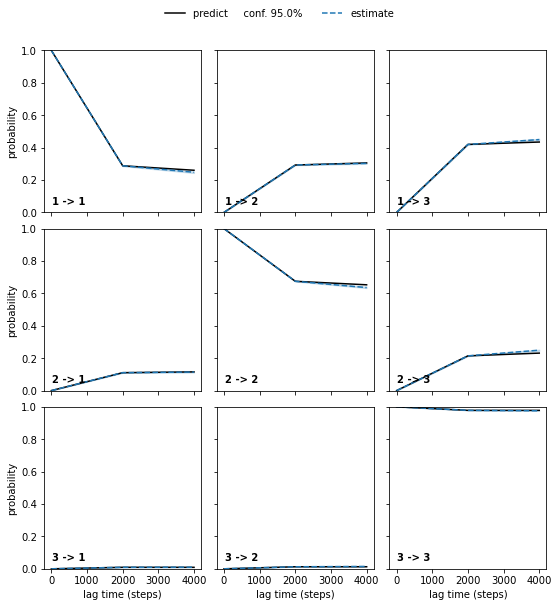

In [37]:
ck = msm.cktest(nsets=3, mlags=3)
pyemma.plots.plot_cktest(ck)

The estimate and predicted probabilities agree well, suggesting that our model is indeed Markovian (i.e. 'memoryless').

### Metastable state analysis

At the moment our MSM tells us about the transition probabilities between 100 states, defined by RMSD to closed WPD loop PTP1B structure and the distance between substrate peptide PTyr(P) and protein Cys215(S). However what we are really interested in is the probability of the protein existing in an active or inactive conformation. Therefore we will be further grouping the 100 states into metastable states using PCAA.

In [41]:
pcaa_results = msm.pcca(2)
colours = ['magenta', 'orange']#, 'teal']
assignments = [[],[],[]]
for i in range(len(pcaa_results.metastable_sets)):
    for j in pcaa_results.metastable_sets[i]:
        assignments[i].append(msm.stationary_distribution[j])
    print(f'{colours[i]} has {len(assignments[i])} counts and {round(sum(assignments[i])*100, 2)}% probability')

magenta has 21 counts and 6.46% probability
orange has 79 counts and 93.54% probability


In [43]:
pcaa_results = msm.pcca(3)
colours = ['magenta', 'orange', 'teal']
assignments = [[],[],[]]
for i in range(len(pcaa_results.metastable_sets)):
    for j in pcaa_results.metastable_sets[i]:
        assignments[i].append(msm.stationary_distribution[j])
    print(f'{colours[i]} has {len(assignments[i])} counts and {round(sum(assignments[i])*100, 2)}% probability')

magenta has 7 counts and 1.82% probability
orange has 14 counts and 4.64% probability
teal has 79 counts and 93.54% probability


Text(0.5, 0, 'RMSD')

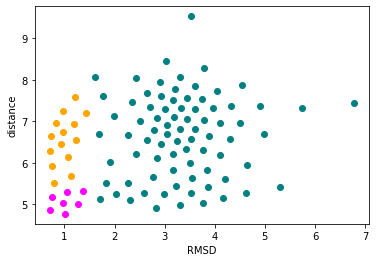

In [45]:
fig, ax = plt.subplots(1)
for i in range(3):
    x = clusters.clustercenters[pcaa_results.metastable_sets[i]][:,0]
    y = clusters.clustercenters[pcaa_results.metastable_sets[i]][:,1]
    ax.scatter(x, y, c=colours[i])
ax.set_ylabel('distance')
ax.set_xlabel('RMSD')